# Benchmark: MBR computation

Benchmark comparing Minimum Bounding Rectangle computation across:

* [georust/geo](https://lib.rs/crates/geo) crate
* The [geos C library](https://trac.osgeo.org/geos/), used through high-level Rust bindings via the [geos](https://lib.rs/crates/geos) crate

## Benchmarked operation

Each iteration computes the Minimum Bounding Rectangle of the multi-polygon representing all districts of India a 100,000 times.

## WARNING

The analysis below shows that GEOS precomputes envolveop and is therefore faster...

# Prerequisites

Generate data:

```sh
cd harness
cargo run --release --bin benchmark_mbr -- --out-file ../analysis/benchmark_mbr/data.json --geojson-file ../data/india_districts/polbnda_ind.geojson --iterations 300 --headlong
```

### Loading data from /mnt/data/source/explore-georust/analysis/benchmark_mbr/data.json
### Statistics: Raw data
                 qps                                            
program          geo         geos   geos_twice geos_twice_cloned
count     200.000000   200.000000   200.000000        200.000000
mean     2876.981849  2008.685996   985.822387        991.297743
std       477.572907   149.554295    57.454741         56.919611
min      2116.254046  1488.605706   764.972938        799.702653
25%      2346.707366  1976.178343   974.519943        980.720987
50%      3207.632933  2025.339024   993.810426        997.884631
75%      3315.896590  2045.917881  1010.376662       1011.827160
max      3340.428705  2762.884358  1170.146624       1171.053049


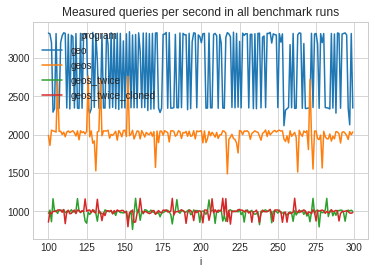

### Statistics: After outlier removal
                 qps                                            
program          geo         geos   geos_twice geos_twice_cloned
count     153.000000   153.000000   153.000000        153.000000
mean     2857.774817  2003.301952   993.106916        996.220850
std       483.088820    53.617797    23.009626         21.387676
min      2116.254046  1761.293958   871.229884        879.092701
25%      2346.199629  1978.334985   983.643914        985.057917
50%      3199.690976  2026.259180   997.546621        998.813261
75%      3316.206574  2045.039567  1010.770961       1010.947465
max      3340.428705  2060.206685  1025.947516       1025.519155


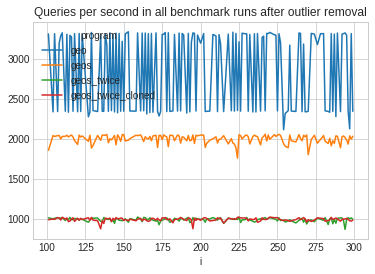

## Ratio of qps compared to geo
                qps                              
program        geos  geos_twice geos_twice_cloned
count    153.000000  153.000000        153.000000
mean       0.721669    0.357667          0.358943
std        0.124796    0.061080          0.062041
min        0.561136    0.262002          0.264531
25%        0.611582    0.302518          0.303247
50%        0.638468    0.312292          0.313716
75%        0.862503    0.422086          0.423940
max        0.958383    0.472362          0.463302


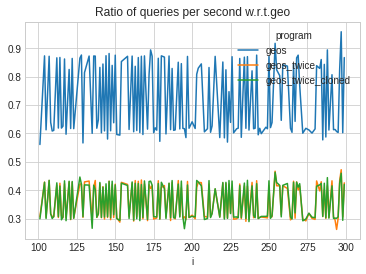

In [1]:
import os
data_absolute_path = os.path.join(os.getcwd(), 'data.json')
%run ../common/benchmark_analysis.ipynb

# Performance benchmarking

To generate the following SVG:

```bash
cd harness
cargo build --release

perf record -F 990 -g -o ../analysis/benchmark_mbr/perf.data -- ./target/release/benchmark_mbr --geojson-file ../data/india_districts/polbnda_ind.geojson --out-file /dev/null --iterations 200 --headlong > /dev/null

cd ../analysis/benchmark_mbr
perf script -i perf.data | ../../third_party/stackcollapse-perf.pl > perf.collapsed-stacks.data
../../third_party/flamegraph.pl perf.collapsed-stacks.data > perf.svg
```

![](./perf.svg)

To dig in further, use
```
perf report -g -i perf.data
```

This shows that over 90% time is spent in `geo_types::private_utils::get_bounding_rect`.

In particular, `getEnvelope` in `libgeos` contributes ~0.13% time: ![](./ReportGetEnvelope.png)

-> My assumption that geo is losing out due to bad memory allocations is wrong.

## It's all just destructors

I didn't hvae geos with debugging information. Much better flamegraph once we have that:
 
![](./perf2.svg)

But somehow, geos became **slower** than geo. (should retry without debugsyms again) Verified that geos is still built with `-O2`.

Also, all the time being measured in geos is just destructors. See `./perf.hist.0`.

![](./only-distructors.png)
